In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import numpy as np
import itertools as it
import mystic.solvers as ms
import time

import generate_alphas as ga
import mom_constraint as mc
import dirichlet as dr
import extreme_data as extr
import damex_algo as dmx
import clef_algo as clf
import em_algo as em

from sklearn.cluster import KMeans

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mlc

In [3]:
# General parameters
d = 20
n = int(1e3)
K = 10
R_dir = 1e2

# Generate alphas
max_size = 8
p_geom = 0.3
true_alphas, feats, alphas_singlet = ga.gen_random_alphas(d,
                                                          K,
                                                          max_size,
                                                          p_geom)
np.save('results/true_alphas.npy', true_alphas)
np.save('results/feats.npy', feats)
np.save('results/alphas_singlet.npy', alphas_singlet)
# true_alphas = list(np.load('results/true_alphas.npy'))
# feats = list(np.load('results/feats.npy'))
alphas_singlet = [[j] for j in list(set(range(d)) - set(feats))]
K_tot = K + len(alphas_singlet)

# Generate Dirichlet mixture
rho_0 = mc.random_rho(true_alphas, d)
means_0, weights_0 = mc.rho_to_means_weights(rho_0)
nu_0 = 20*np.ones(K)
lbda_0 = 0.5*np.ones(K_tot)
noise_func = 'expon'
x_dir, y_label = dr.dirichlet_mixture(means_0, weights_0, nu_0, lbda_0,
                                      true_alphas, alphas_singlet,
                                      d, n, noise_func, R_dir)
theta_0 = mc.rho_nu_to_theta(rho_0, nu_0, true_alphas)
np.save('results/theta_0.npy', theta_0)
np.save('results/lbda_0.npy', lbda_0)
np.save('results/x_dir.npy', x_dir)
np.save('results/y_label.npy', y_label)
# theta_0 = np.load('results/theta_0.npy')
# lbda_0 = np.load('results/lbda_0.npy')
# x_dir = np.load('results/x_dir.npy')
# y_label = np.load('results/y_label.npy')

In [4]:
# Find sparse structure
R = 50
# Damex
eps_dmx = 0.3
mu_min = 0.002
alphas_dmx, mass = dmx.damex(x_dir, R, eps_dmx, mu_min)
alphas_dmx = clf.find_maximal_alphas(dmx.list_to_dict_size(alphas_dmx))
res = list(map(len, extr.check_errors(true_alphas, alphas_dmx, d)))
print(f'recovered faces: {res[0]}/{K}')
print(f'nb of subsets of true faces: {res[3]}')
print(f'nb of supsets of true faces: {res[4]}')
print(f'neither: {res[2]}')

recovered faces: 10/10
nb of subsets of true faces: 0
nb of supsets of true faces: 0
neither: 0


In [5]:
# Extreme points
R_extr = 1e2
ind_extr = np.sum(x_dir, axis=1) > R_extr
x_extr = x_dir[ind_extr]

# Empirical rho
alphas = true_alphas
means_emp = [np.mean(em.project_on_simplex(x_extr, alpha), axis=0)
             for alpha in alphas]
weights_emp = np.ones(K)/K
rho_emp = mc.means_weights_to_rho(means_emp, weights_emp, alphas)

# Rho that verify moment constraint
rho_init = mc.project_rho(rho_emp, d)

# Init
nu_init = 20*np.ones(K)
theta_init = mc.rho_nu_to_theta(rho_init, nu_init, alphas)
lbda_init = 1.*np.ones(K_tot)
print('rho err init: ', np.sqrt(np.sum((rho_init - rho_0)**2)))
print('nu err init: ', np.sqrt(np.sum((nu_init - nu_0)**2)))
print('lbda err init: ', np.sqrt(np.sum((lbda_init - lbda_0)**2)))
gamma_z_init = em.compute_gamma_z(x_extr, theta_init, lbda_init,
                                  alphas, alphas_singlet,
                                  noise_func)
Q_tot = em.Q_tot(theta_init, lbda_init, x_extr, gamma_z_init,
                 alphas, alphas_singlet,
                 noise_func)
cplt_lhood = em.complete_likelihood(x_extr, theta_init, lbda_init,
                                    alphas, alphas_singlet,
                                    noise_func)

# Constraints
theta_constraint = mc.Theta_constraint(alphas, d)

# Bounds
bds_r = [(0, 1./d) for i in range(len(theta_init[:-K]))]
bds_n = [(0, None) for i in range(K)]
bds = bds_r + bds_n
n_loop = 20

t_0 = time.clock()
# EM algorithm
theta = np.copy(theta_init)
gamma_z = np.copy(gamma_z_init)
lbda = np.copy(lbda_init)
gamma_z_list = [gamma_z]
lbda_list = [lbda]
theta_list = [theta]
check_list = [(-Q_tot, cplt_lhood)]
cpt = 0
crit_diff = 2.
while crit_diff > 1. and cpt < n_loop:
    # E-step
    gamma_z = em.compute_gamma_z(x_extr, theta, lbda,
                                 alphas, alphas_singlet,
                                 noise_func)
    gamma_z_list.append(gamma_z)
    # M-step
    # Minimize in lambda
    if noise_func == 'expon':
        lbda = em.compute_new_lambda(x_extr, gamma_z,
                                     alphas, alphas_singlet)
    if noise_func == 'pareto':
        lbda = em.compute_new_pareto(x_extr, gamma_z,
                                     alphas, alphas_singlet)
    lbda_list.append(lbda)
    # Minimize in theta
    theta = ms.diffev(em.Q, theta,
                      args=(x_extr, gamma_z, alphas),
                      bounds=bds,
                      constraints=theta_constraint)
    theta_list.append(theta)
    rho, nu = mc.theta_to_rho_nu(theta, alphas, d)
    print('rho err: ', np.sqrt(np.sum((rho - rho_0)**2)))
    print('nu err: ', np.sqrt(np.sum((nu - nu_0)**2)))
    print('lbda err: ', np.sqrt(np.sum((lbda - lbda_0)**2)))
    # New likelihood
    Q_tot_ = em.Q_tot(theta, lbda, x_extr, gamma_z,
                      alphas, alphas_singlet,
                      noise_func)
    cplt_lhood_ = em.complete_likelihood(x_extr, theta, lbda,
                                         alphas, alphas_singlet,
                                         noise_func)
    crit_diff = abs(Q_tot_ - Q_tot)
    Q_tot = Q_tot_
    cplt_lhood = cplt_lhood_
    check_list.append((-Q_tot, cplt_lhood))
    cpt += 1
t_em = time.clock() - t_0
np.save('results/theta_res.npy', theta)
np.save('results/lbda_res.npy', lbda)
np.save('results/gamma_z_res.npy', gamma_z)

rho err init:  0.01822576645603438
nu err init:  0.0
lbda err init:  1.5811388300841898
Optimization terminated successfully.
         Current function value: -648.712537
         Iterations: 731
         Function evaluations: 24888
rho err:  0.0034604023651521204
nu err:  13.09421439153687
lbda err:  0.044763171623531904
Optimization terminated successfully.
         Current function value: -648.712537
         Iterations: 30
         Function evaluations: 1054
rho err:  0.0034604023651521204
nu err:  13.09421439153687
lbda err:  0.04476317162386223


### Test and visualization

In [6]:
true_alphas = list(np.load('results/true_alphas.npy'))
feats = list(set([j for alph in true_alphas for j in alph]))
alphas_singlet = [[j] for j in list(set(range(d)) - set(feats))]
K_tot = K + len(alphas_singlet)
theta_0 = np.load('results/theta_0.npy')
lbda_0 = np.load('results/lbda_0.npy')
labels_0 = np.load('results/y_label.npy')
rho_0, nu_0 = mc.theta_to_rho_nu(theta_0, true_alphas, d)
means_0, weights_0 = mc.rho_to_means_weights(rho_0)
noise_func = 'expon'

# Test data
x_test, y_label = dr.dirichlet_mixture(means_0, weights_0, nu_0, lbda_0,
                                       true_alphas, alphas_singlet,
                                       d, n, noise_func, R_dir)

In [7]:
# Estimated parameters
theta = np.load('results/theta_res.npy')
rho, nu = mc.theta_to_rho_nu(theta, true_alphas, d)
lbda = np.load('results/lbda_res.npy')
gamma_z = np.load('results/gamma_z_res.npy')
print('err rho', np.mean(abs(rho - rho_0)))
print('err nu', np.mean(abs(nu - nu_0)))
print('err lbda', np.mean(abs(lbda - lbda_0)))
print('err labels', np.sum(np.argmax(gamma_z, axis=1) != labels_0))

# Extreme points
R_extr = 1e2
ind_extr = np.sum(x_test, axis=1) > R_extr
x_extr_test = x_test[ind_extr]

# Compute conditional probability {x from \alpha}
gamma_z_test = em.compute_gamma_z(x_extr_test,
                                  theta, lbda,
                                  true_alphas, alphas_singlet,
                                  noise_func)

err rho 6.725259659037885e-05
err nu 2.5777215469052432
err lbda 0.010387066946103179
err labels 0


/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/home/mael/miniconda3/envs/evt/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


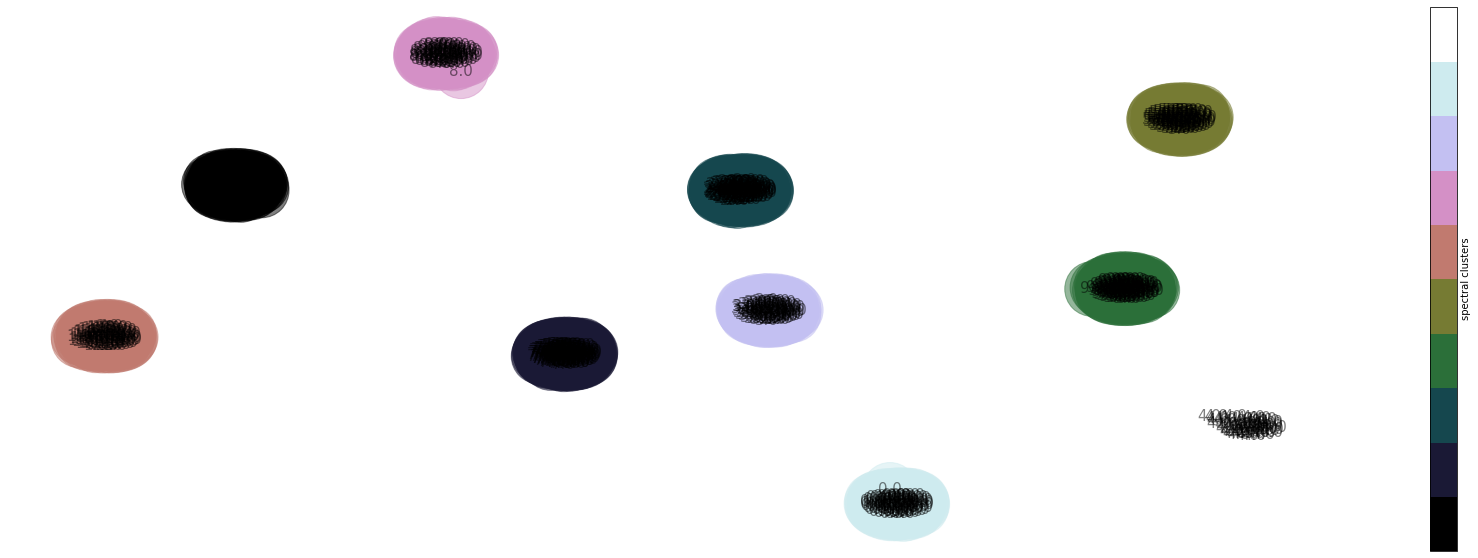

In [8]:
# Adjacency Matrix
n_extr, K = np.shape(gamma_z_test)
W = np.zeros((n_extr, n_extr))
for (i, j) in it.combinations(range(n_extr), 2):
    W[i, j] = np.sum(gamma_z_test[i] * gamma_z_test[j])
    W[j, i] = W[i, j]

# Spectral clustering
K_spec = K_tot
L = np.diag(np.sum(W, axis=1)) - W
eigval, eigvect = np.linalg.eigh(L)
kmeans = KMeans(n_clusters=K_spec).fit(eigvect[:, :K_spec])
labels = kmeans.labels_

# Networkx visualisation 0
G = nx.from_numpy_matrix(W)
W_min = np.mean(W)/2
W_thresh = W*(W > W_min)
G_edges = []
weights_edges = []
for edge in G.edges():
    if W_thresh[edge] > W_min:
        G_edges.append(edge)
        weights_edges.append(W_thresh[edge])
G_visu = nx.from_numpy_matrix(W_thresh)
labels_dict = {i: str(y_label[i])
               for i in range(n_extr)}

fig, ax = plt.subplots(figsize=(30, 10))
cmap = plt.get_cmap('cubehelix', K_spec)
pos = nx.spring_layout(G_visu, k=0.1)
nx.draw(G_visu,
        pos=pos,
        edgelist=G_edges,
        node_size=3e3,
        node_color=labels/float(K_spec),
        alpha=0.5,
        cmap=cmap,
        edge_color=np.array(weights_edges),
        edge_cmap=plt.get_cmap(name='Reds'),
        font_size=15,
        labels=labels_dict)
sm = plt.cm.ScalarMappable(cmap=cmap)
sm._A = []
plt.colorbar(sm, ticks=[-0.5, K_spec+0.5], label='spectral clusters', ax=ax)
plt.show()

# # Networkx visualisation with agglomerated points
# W_clusters = np.zeros((K_spec, K_spec))
# for k_0 in range(K_spec-1):
#     for k_1 in range(k_0+1, K_spec):
#         inds_k_0 = np.nonzero(labels == k_0)[0]
#         inds_k_1 = np.nonzero(labels == k_1)[0]
#         W_clusters[k_0, k_1] = np.sum(W[inds_k_0, :][:, inds_k_1])
#         W_clusters[k_1, k_0] = W_clusters[k_0, k_1]
# G_clusters = nx.from_numpy_matrix(W_clusters)
# node_color = []
# for node in G_clusters.nodes():
#     inds = np.nonzero(labels == node)[0]
#     node_color.append(np.sum(W[inds, :][:, inds])/np.sum(inds))
# G_clust_edges = []
# w_edges = []
# for edge in G_clusters.edges():
#     if W_clusters[edge] > 0.:
#         G_clust_edges.append(edge)
#         w_edges.append(W_clusters[edge])
# node_size = [np.sum(labels == k) for k in range(K_spec)]
# cmap = plt.get_cmap(name='gnuplot_r')
# cmaplist = [cmap(i) for i in range(cmap.N)]
# new_cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)
# bounds = np.linspace(0, K_spec, K_spec+1)
# norm = mlc.BoundaryNorm(bounds, cmap.N)
# labels_dict = {k: str(node_size[k]) for k in range(K_spec)}

# nx.draw(G_clusters,
#         node_size=100*np.array(node_size),
#         node_color=node_color,
#         alpha=0.5,
#         cmap=cmap,
#         edge_color=np.array(w_edges),
#         edge_cmap=plt.get_cmap(name='Reds'),
#         font_size=8,
#         labels=labels_dict)
# sm = plt.cm.ScalarMappable(cmap=new_cmap, norm=norm)
# sm._A = []
# plt.colorbar(sm)
# plt.show()